In [64]:
#!pip install skforecast

#Librerías para cálculos y gráficos
#====================================================================================
import pandas as pd
import numpy as np
from numpy import array
import plotly.graph_objs as go
import matplotlib.pyplot as plt
#pip install matplotlib==3.7.1
import seaborn as sns

#Librerías para Preprocesamiento de datos
#====================================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


#Librerías para Implementación de Modelos
#====================================================================================
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tsfeatures import tsfeatures

In [65]:
start = '2016-05-01'
end = '2018-01-28'
ticker = 'META'
data = pd.DataFrame(pdr.get_data_yahoo(ticker, start, end)['Close'])

[*********************100%***********************]  1 of 1 completed


In [66]:
df = data.copy()
df = df.reset_index()
df['Date'] = df['Date'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    439 non-null    object 
 1   Close   439 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


In [67]:
año = list(range(2016,2028,1))
df['AÑO'] = ""

for i in año:
  df.loc[(df['Date'].str.contains(str(i)) == True),'AÑO']= i

mes = list(range(1,13,1))
df['MES'] = ""

for i in range(0,10):
   df.loc[(df['Date'].str.contains("-0"+str(i)+"-") == True),'MES']= i
for i in range(10,13):
   df.loc[(df['Date'].str.contains("-"+str(i)+"-") == True),'MES']= i

Text(0.5, 1.0, 'Comportamiento anual de la acción de META entre los años 2016 a 2018')

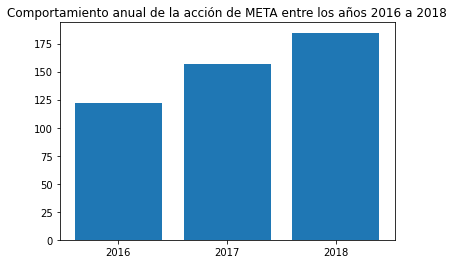

In [68]:
anual = df.groupby(by='AÑO').mean()

x = list(anual.index)
y = anual['Close']

plt.bar(x,y)
plt.xticks(range(2016,2019,1))
plt.title("Comportamiento anual de la acción de META entre los años 2016 a 2018")

In [69]:
mensual = df.groupby(by=['AÑO','MES']).mean()
mensual = mensual.reset_index()

datos = mensual[mensual['AÑO']==2016]
trace1 = go.Scatter(
    x = list(range(0,13,1)),
    y = datos['Close'],
    mode = 'lines',
    name = '2016'
)

datos = mensual[mensual['AÑO']==2017]
trace2 = go.Scatter(
    x = list(range(0,13,1)),
    y = datos['Close'],
    mode = 'lines',
    name = '2017'
)

datos = mensual[mensual['AÑO']==2018]
trace3 = go.Scatter(
    x = list(range(0,13,1)),
    y = datos['Close'],
    mode = 'lines',
    name = '2018'
)

layout = go.Layout(
    title = "S&P Comportamiento mensual del Precio de Cierre de META años 2016 a 2018",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Precios"}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 439 entries, 2016-05-02 to 2018-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   439 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB


# Red neuronal

In [71]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import plotly.graph_objs as go

# univariate one step problem with lstm
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [72]:
dataindex= pd.to_datetime(data.index)


df2= data.to_numpy()
close_data = df2.reshape((-1,1))

In [73]:
#Especificamos primeramente el porcentje del corte.
split_percent = 0.95
split = int(split_percent*len(close_data))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
close_train = close_data[:split]
close_test = close_data[split:]

date_train = dataindex[:split]
date_test = dataindex[split:]

In [74]:
print(len(close_train))
print(len(close_test))

417
22


Realiza el preprocesamiento necesario para aplicar cada uno de los modelos. En el caso de LSTM diseña y entrena la red con 200 nodos, la función de activación “relu”, epochs=30, función de perdida de ‘mse’, longitud de ventana de 10 yoptimizer='adam'.

In [75]:
#Especificamos la longitud o length, es el número de observaciones tipo lags a emplear en la prción de entrada de cada muestra, el ejemplo anterior era de 3.
#batch size representa en número de sub-series o muestras a generar en cada lote. En este caso, pueden ser uno o más. Por ejemplo, en la imagen anterior, el batch size es de 3.
n_back = 10   #la longitud 
train_generator = TimeseriesGenerator(close_train, close_train, length=n_back, batch_size=25)     
test_generator = TimeseriesGenerator(close_test, close_test, length=n_back, batch_size=1)

In [76]:
# Podemos ver el número de muestras que se prepararán en los datos por el generador para esta serie
print('Samples: %d' % len(train_generator))
print('Samples: %d' % len(test_generator))

Samples: 17
Samples: 12


In [77]:
##Neural Net
#Importamos primero los módulos requeridos:
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Configuramos la de red.
model = Sequential()
model.add(
    LSTM(200,  ## de nodos, dependerá de su poder de cómputo.
        activation='relu',
        input_shape=(n_back,1))   ##la longitud de la secuencia
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 30
model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

In [78]:
##Ajuste del modelo a los datos:
history = model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

In [79]:
#Predicción en el set de prueba:
prediction = model.predict_generator(test_generator)

#El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [80]:
y_true = close_test[n_back:]
y_pred = prediction

In [81]:
#Evaluar el rendimiento del modelo
test_loss = model.evaluate(test_generator)
print('Test loss MSE:', test_loss)

12/12 [==============================] - 0s 3ms/step - loss: 31.5645
Test loss MSE: 31.564538955688477


In [82]:
from sklearn.metrics import mean_absolute_percentage_error

error_mse = mean_squared_error(
                    y_true= y_true,
                    y_pred = y_pred
                )

rmse = np.sqrt (error_mse)

print(f"EL MSE del modelo en test es de: {error_mse}")
print(f"EL RMSE del modelo en test es de: {rmse}")

# suponga que y_true son los valores reales y y_pred son las predicciones del modelo
error_mae = mean_absolute_error(
                y_true= y_true,
                y_pred = y_pred
            )
print(f"EL MAE del modelo en test es de: {error_mae}")

mape = mean_absolute_percentage_error(y_true, y_pred)
print("EL MAPE del modelo en test es de: {:.2f}%".format(mape*100))

metricas_lstm = [error_mse,rmse,error_mae,mape]

EL MSE del modelo en test es de: 31.564436882055208
EL RMSE del modelo en test es de: 5.618223641156981
EL MAE del modelo en test es de: 4.963685353597005
EL MAPE del modelo en test es de: 2.67%


In [83]:
##Forecasting: Generamos el pronóstico hacia adelante acorde el modelo entrenado, a partir de la última fecha. en este caso generaremos 10 observaciones futuras y finalmente anexaremos las fechas correspondientes.
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = max(data.index)  #se podría sustituir por un objeto con el valor máximo de la longitud de la serie.
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1, freq='B').tolist()  #Aquí, sebemos ser coherentes con la frecuencia de la serie, el defalult es diario.
    return prediction_dates


In [84]:
num_prediction = 10
pred_rn = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 20ms/step


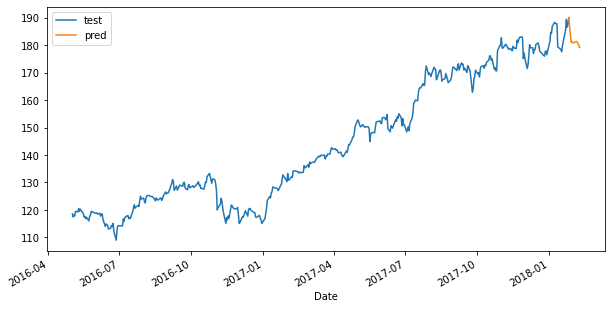

In [85]:
pred_rn = pd.DataFrame(zip(forecast_dates,pred_rn),columns=['Date','pred'])
pred_rn = pred_rn.set_index('Date')

fig, ax = plt.subplots(figsize=(10, 5))
data['Close'].plot(ax=ax, label='test')
pred_rn.plot(ax=ax, label='predicciones')
ax.legend();

# SKForecaster

In [86]:
dataindex= pd.to_datetime(data.index)

df_sk= pandas.DataFrame(df).iloc[:,:2]

#Especificamos primeramente el porcentje del corte.
split_percent = 0.95
split = int(split_percent*len(df_sk))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
sk_train = df_sk[:split]
sk_test = df_sk[split:]

datesk_train = dataindex[:split]
datesk_test = dataindex[split:]

print(len(sk_train)), print(len(sk_test))

417
22


(None, None)

In [87]:
sk_train

,Date,Close
0,2016-05-02,118.570000
1,2016-05-03,117.430000
2,2016-05-04,118.059998
3,2016-05-05,117.809998
4,2016-05-06,119.489998
...,...,...
412,2017-12-18,180.820007
413,2017-12-19,179.509995
414,2017-12-20,177.889999
415,2017-12-21,177.449997


In [100]:
# Cálculo de hiperparámetros por grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 # Este valor se reemplazará en la grilla
             )

# Lags used as predictors
lags_grid = [10, 15,20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100,300, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = sk_train['Close'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(sk_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

#`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
#  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
#  Parameters: {'max_depth': 10, 'n_estimators': 100}
#  Backtesting metric: 38.7095871026073

Number of models compared: 27.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [04:38<00:00, 92.88s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 38.7095871026073



In [89]:
steps = len(sk_test)
pred_sk = forecaster.predict(steps=steps)

In [90]:
y_true = sk_test['Close']
y_pred = pred_sk

In [91]:
error_mse = mean_squared_error(
                    y_true= y_true,
                    y_pred = y_pred
                )

rmse = np.sqrt (error_mse)

print(f"EL MSE del modelo en test es de: {error_mse}")
print(f"EL RMSE del modelo en test es de: {rmse}")

# suponga que y_true son los valores reales y y_pred son las predicciones del modelo
error_mae = mean_absolute_error(
                y_true= y_true,
                y_pred = y_pred
            )
print(f"EL MAE del modelo en test es de: {error_mae}")

mape = mean_absolute_percentage_error(y_true, y_pred)
print("EL MAPE del modelo en test es de: {:.2f}%".format(mape*100))

metricas_sk = [error_mse,rmse,error_mae,mape]

EL MSE del modelo en test es de: 39.83573072605286
EL RMSE del modelo en test es de: 6.311555333359033
EL MAE del modelo en test es de: 5.089508666015609
EL MAPE del modelo en test es de: 2.73%


In [92]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",38.709587,10,100
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",38.887570,5,100
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",39.223455,5,500
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",39.416511,10,500
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",45.854436,10,100
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",46.327037,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 5, 'n_estimators': 500}",46.730369,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 10, 'n_estimators': 500}",46.789559,10,500
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",46.952928,5,100
8,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 5, 'n_estimators': 100}",47.282550,5,100


In [93]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.286230
1,lag_2,0.163335
2,lag_3,0.306064
3,lag_4,0.106653
4,lag_5,0.089155
5,lag_6,0.006854
6,lag_7,0.000791
7,lag_8,0.010212
8,lag_9,0.007253
9,lag_10,0.001911


In [94]:
# Configuramos la función de pronóstico de forecaster con la mejor combinación obteida de hiperparámetros.
# ==============================================================================
### Aquí debe ir tu codigo, 
regressor = RandomForestRegressor(max_depth=10 , n_estimators=100 , random_state=123)
### Hasta aquí modificas

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=df_sk['Close'])

In [95]:
# Pronóstico, en este caso elegimos una ventana de 20 días.
# ==============================================================================
steps = 10
pred_skf = forecaster.predict(steps=steps)

In [103]:
df_sk = df_sk.set_index('Date')
df_sk

,Close
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998
...,...
2018-01-22,185.369995
2018-01-23,189.350006
2018-01-24,186.550003


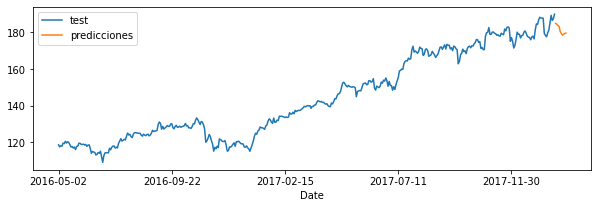

In [99]:
# Calculamos las métricas
# ==============================================================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))
df_sk['Close'].plot(ax=ax, label='test')
pred_skf.plot(ax=ax, label='predicciones')
ax.legend();